# 1. Preparación de Entorno. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

# 2. Carga de Datos. 

## Acuíferos. 

In [ ]:
# Load the aquifer hydrology data
df_aquifers = pd.read_csv("../data/processed/aquifers/aquifer_hydrology_data_clean.csv")
df_aquifers.head()

,Date,Value,Medition_Types,Location
0,1999-01-01,0.0,1,1
1,2000-01-01,0.0,1,1
2,2001-01-01,0.0,1,1
3,2002-01-01,0.0,1,1
4,2003-01-01,0.0,1,1


## Lagos. 

In [5]:
# Load the lake hydrology data
df_lakes = pd.read_csv("../data/processed/lakes/lake_hydrology_data_clean.csv")
df_lakes.head()

,Date,Value,Measurement_Types,Location
0,2002-06-03,0.0,1,1
1,2002-06-04,0.0,1,1
2,2002-06-05,0.0,1,1
3,2002-06-06,0.0,1,1
4,2002-06-07,0.0,1,1


## Ríos. 

In [6]:
# Load the river hydrology data
df_rivers = pd.read_csv("../data/processed/rivers/river_hydrology_data_clean.csv")
df_rivers.head()

,Date,Value,Measurement_Types,Location
0,1998-01-01,0.0,1,1
1,1998-01-02,0.0,1,1
2,1998-01-03,0.0,1,1
3,1998-01-04,0.0,1,1
4,1998-01-05,0.0,1,1


## Manantiales. 

In [7]:
# Load the water spring hydrology data
df_water_spring = pd.read_csv("../data/processed/water_spring/water_spring_hydrology_data_clean.csv")
df_water_spring.head()

,Date,Value,Measurement_Types,Location
0,2000-01-01,0.0,1,1
1,2001-01-01,0.0,1,1
2,2002-01-01,0.0,1,1
3,2003-01-01,0.0,1,1
4,2004-01-01,0.0,1,1


# 3. Definir Features (X) y Variable Target (Y). 

Para definir las variables features y la variable target, se considerarán los datos que nos son útiles para visualizar el nivel de agua según la fecha de cada cuerpo de agua, en este caso __"Value"__ es la variable target, mientras que el resto de las variables se considerarán variables feature.

# 4. Dividir data en train y test. 

In [8]:
import pandas as pd

def split_time_series_by_percentage(df, split_percentage):
    """
    Splits a time series DataFrame into training and testing sets
    based on a specified percentage. The DataFrame must be ordered chronologically.

    Args:
        df (pd.DataFrame): The input time series DataFrame.
        split_percentage (float): The percentage of data to use for the training set (e.g., 0.8 for 80%).

    Returns:
        tuple: A tuple containing the training and testing DataFrames (train_df, test_df).
    """
    if not 0 < split_percentage < 1:
        raise ValueError("split_percentage must be between 0 and 1.")

    split_point = int(len(df) * split_percentage)
    
    train_df = df.iloc[:split_point]
    test_df = df.iloc[split_point:]
    
    return train_df, test_df

# Example usage:
# Assuming 'df' is your time series DataFrame, already sorted by date.
# train_data, test_data = split_time_series_by_percentage(df, 0.8)

# print("Train Data:")
# print(train_data)
# print("\nTest Data:")
# print(test_data)

In [ ]:
# Split the aquifer data into training and testing sets
train_data_aquifers, test_data_aquifers = split_time_series_by_percentage(df_aquifers, 0.8)

In [10]:
# Split the lakes data into training and testing sets
train_data_lakes, test_data_lakes = split_time_series_by_percentage(df_lakes, 0.8)

In [11]:
# Split the rivers data into training and testing sets
train_data_rivers, test_data_rivers = split_time_series_by_percentage(df_rivers, 0.8)

In [12]:
# Split the water_spring data into training and testing sets
train_data_water_spring, test_data_water_spring = split_time_series_by_percentage(df_water_spring, 0.8)

# 5. Evaluar modelos e Hiperpárametros.

In [19]:
df_aquifers['Date'] = pd.to_datetime(df_aquifers['Date'], errors='coerce')

In [20]:
df_aquifers['Date'] = df_aquifers['Date'].dt.date

In [21]:
all_data = df_aquifers.set_index('Date')

In [22]:
ts = all_data["Value"]

In [23]:
ts.head()

Date
2002-06-03    0.0
2002-06-04    0.0
2002-06-05    0.0
2002-06-06    0.0
2002-06-07    0.0
Name: Value, dtype: float64

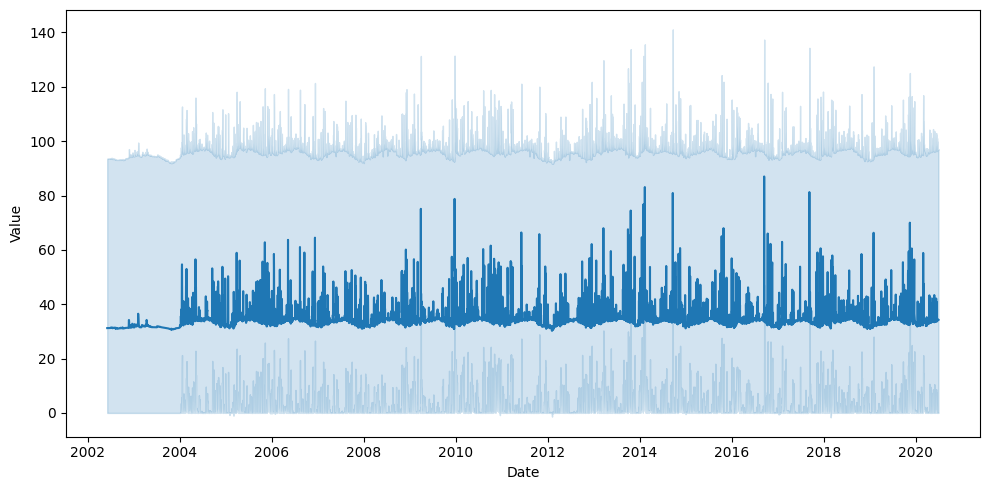

In [24]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)

plt.tight_layout()

plt.show()

# 6. Guardar Modelos. 